In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gdp

from sklearn.cluster import SpectralClustering
import numpy as np
import networkx as nx
import os
import sys
import pickle
import re

from shapely.geometry import Polygon, MultiPolygon
from descartes import PolygonPatch

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib import ticker
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors



In [2]:
prjDir = "/home/charles/Projects/QcMtlStreets"
sys.path.append(os.path.join(prjDir, "Python"))   
from OsmnxElev import *

# Get the 5 la cite limoilou neighbourhoods defining the upper and lower city

In [3]:
listNeigh = ["Saint-Jean-Baptiste", 
             "Vieux-Québec/Cap-Blanc/Colline parlementaire",
            "Montcalm",
            "Saint-Sauveur",
            "Saint-Roch"]

In [4]:
graphSJB, shpQcSJB, dfPointsSubsetQcSJB = getInducedSubgraphNeighQc(listNeigh)

File exists => reading graph
There are  0.17462765309849437  of points in the bounding box in neighbourhoods Saint-Jean-Baptiste, Vieux-Québec/Cap-Blanc/Colline parlementaire, Montcalm, Saint-Sauveur, Saint-Roch


In [5]:
dfEdgesSJB = getAllListEdgesDirectedMultigraph(graphSJB,
                                                    listNeigh=listNeigh,
                                                    listFeat=['grade_abs', 'bearing'])

In getAllListEdgesDirectedMultigraph => adding edge bearings


In [6]:
dfEdgesSJB.head()

startNode           startNeigh       endNode             endNeigh  \
0  1.832233e+09  Saint-Jean-Baptiste  1.832233e+09  Saint-Jean-Baptiste   
1  1.774756e+08  Saint-Jean-Baptiste  1.774762e+08  Saint-Jean-Baptiste   
2  1.774756e+08  Saint-Jean-Baptiste  1.652178e+08  Saint-Jean-Baptiste   
3  1.774756e+08  Saint-Jean-Baptiste  3.048305e+08  Saint-Jean-Baptiste   
4  1.832233e+09  Saint-Jean-Baptiste  2.477819e+09  Saint-Jean-Baptiste   

   grade_abs  bearing  startIdx  endIdx pairIdxDirected pairIdxUndirected  \
0     0.1264  350.087         1       1          (1, 1)            (1, 1)   
1     0.0324  328.701         1       1          (1, 1)            (1, 1)   
2     0.0303   58.025         1       1          (1, 1)            (1, 1)   
3     0.0296  238.391         1       1          (1, 1)            (1, 1)   
4     0.2838   15.665         1       1          (1, 1)            (1, 1)   

                          neighPairUndirected  \
0  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)   
1  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)   
2  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)   
3  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)   
4  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)   

                            neighPairDirected  
0  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)  
1  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)  
2  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)  
3  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)  
4  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)

# Try to determine what % of street names contain 'cote'

In [7]:
def getNameSafe(dat,verbose=False):
    
    try:
        name=dat['name']
    except Exception as e:
        name=None
        if(verbose):
            print("Fatal error with ", str(dat))
        
    return(name)

In [8]:
listStreetNamesRaw = [ getNameSafe(dat) for u,v,dat in graphSJB.edges.data()   ]
listStreetNames=np.unique([ l for l in listStreetNamesRaw if l is not None])

In [9]:
len(listStreetNames)

464

In [10]:
listStreetNames[:10]

array(["Ancienne côte de l'Escarpe", 'Autoroute Charest Ouest',
       'Autoroute Dufferin-Montmorency', 'Autoroute Laurentienne',
       'Avenue Belvédère', 'Avenue Briand', 'Avenue Brown',
       'Avenue Cartier', 'Avenue Casot', 'Avenue Chouinard'], dtype='<U57')

In [11]:
grepR=[re.match( "promenade" , n, re.IGNORECASE) for n in listStreetNames ]
idx=[g is not None for g in grepR]
listStreetNames[idx]

array(['Promenade Samuel-De-Champlain',
       'Promenade Samuel-De-Champlain;Rivière Saint-Charles (sud)',
       'Promenade des Gouverneurs'], dtype='<U57')

# There are supposed to be close to 30 stairs in la cite limouiloui

#References: https://www.ville.quebec.qc.ca/citoyens/patrimoine/quartiers/escaliers/index.aspx
#https://www.quebecurbain.qc.ca/2004/11/08/trente-escaliers-racontent-lhistoire-de-quebec/

In [12]:
def isOnlyEscalierInName(name):
    try:
        escalierGrep= "[eE]scalier|promenade des gouverneurs" 
        boolReturn=re.match( escalierGrep ,name ,re.IGNORECASE) is not None
    except Exception as e:
        boolReturn=False
        print(f"Fatal error with name {name}")
        
    return(boolReturn)

In [13]:
indicesEscalierOnlyInName=[isOnlyEscalierInName(n) for n in listStreetNames ]
print(np.sum((indicesEscalierOnlyInName)))

35


In [14]:
listStreetNames[indicesEscalierOnlyInName]

array(['Escalier Badélard', 'Escalier Cap-Blanc', 'Escalier Casse-cou',
       'Escalier Charles-Baillargé', 'Escalier Colbert',
       'Escalier Des Glacis', 'Escalier Frontenac', 'Escalier Joffre',
       'Escalier Lavigueur', 'Escalier Lépine', 'Escalier Saint-Denis',
       'Escalier Saint-Flavien', 'Escalier Victoria',
       'Escalier central du Parlement', 'Escalier de la Chapelle',
       'Escalier de la Pente-Douce', 'Escalier de la Terrasse',
       'Escalier de la porte Kent', 'Escalier de la porte Saint-Jean',
       'Escalier de la porte Saint-Louis', 'Escalier des Franciscains',
       'Escalier des Glacis', 'Escalier des murs de la Citadelle',
       'Escalier du Cul-de-Sac', 'Escalier du Faubourg',
       'Escalier du Magasin-du-Roi', 'Escalier du Musée',
       'Escalier du Parc des Braves', 'Escalier du Passage du roi',
       'Escalier du Quai-du-Roi', 'Escalier du parc Montmorency',
       'Escalier du parc des Braves', 'Escalier nord du Parlement',
       'Escalier

# Get all streets that refer to a rise in elevation

In [15]:
def isCoteEscalierInName(name):
    try:
        coteStreGrep= "[eE]scalier|[cC]ôte|[pP]ente|[mM]ontée|[cC]oulée|[eE]scarp.*" 
        boolReturn=re.match( coteStreGrep ,name ) is not None
    except Exception as e:
        boolReturn=False
        print(f"Fatal error with name {name}")
        
    return(boolReturn)

In [16]:
indicesCoteInName=[isCoteEscalierInName(n) for n in listStreetNames ]
print( np.sum(indicesCoteInName) , np.sum(indicesCoteInName)/len(indicesCoteInName) )

50 0.10775862068965517


In [17]:
listStreetNames[indicesCoteInName]

array(['Côte Badelard', 'Côte De Salaberry', 'Côte Dinan', 'Côte Gilmour',
       'Côte Sainte-Geneviève', "Côte d'Abraham", "Côte de l'Aqueduc",
       "Côte de l'Escarpe", 'Côte de la Canoterie',
       'Côte de la Citadelle', 'Côte de la Fabrique',
       'Côte de la Montagne', 'Côte de la Pente-Douce',
       'Côte de la Potasse', 'Côte du Colonel-Dambourgès',
       'Côte du Palais', 'Escalier Badélard', 'Escalier Cap-Blanc',
       'Escalier Casse-cou', 'Escalier Charles-Baillargé',
       'Escalier Colbert', 'Escalier Des Glacis', 'Escalier Frontenac',
       'Escalier Joffre', 'Escalier Lavigueur', 'Escalier Lépine',
       'Escalier Saint-Denis', 'Escalier Saint-Flavien',
       'Escalier Victoria', 'Escalier central du Parlement',
       'Escalier de la Chapelle', 'Escalier de la Pente-Douce',
       'Escalier de la Terrasse', 'Escalier de la porte Kent',
       'Escalier de la porte Saint-Jean',
       'Escalier de la porte Saint-Louis', 'Escalier des Franciscains',
       '

# Create a df of edges with the name and the indicator for stairs

In [18]:
dfEdgesWithName=pd.DataFrame([ {'startNode':u, 'endNode':v, 'streetName': getNameSafe(dat)}  for u,v,dat in graphSJB.edges.data() if getNameSafe(dat) is not None   ])

In [19]:
dfEdgesWithName['isCoteEscalier'] = [isCoteEscalierInName(n) for n in dfEdgesWithName['streetName'] ]
dfEdgesWithName['isOnlyEscalierInName'] = [isOnlyEscalierInName(n) for n in dfEdgesWithName['streetName'] ]

In [20]:
dfEdgesWithName.head()

endNode  startNode                     streetName  isCoteEscalier  \
0  2541611721  884736055  Promenade Samuel-De-Champlain           False   
1   884736167  884736055  Promenade Samuel-De-Champlain           False   
2   884736189  884736061                   Tronc Commun           False   
3  2302763158  884736061                   Tronc Commun           False   
4  2302763049  884736073  Promenade Samuel-De-Champlain           False   

   isOnlyEscalierInName  
0                 False  
1                 False  
2                 False  
3                 False  
4                 False

In [21]:
dfEdgesSJBWithName=pd.merge( dfEdgesSJB,
        dfEdgesWithName,
        how='left',
        on=['startNode','endNode'])

In [22]:
dfEdgesSJBWithName.head()

startNode           startNeigh       endNode             endNeigh  \
0  1.832233e+09  Saint-Jean-Baptiste  1.832233e+09  Saint-Jean-Baptiste   
1  1.774756e+08  Saint-Jean-Baptiste  1.774762e+08  Saint-Jean-Baptiste   
2  1.774756e+08  Saint-Jean-Baptiste  1.652178e+08  Saint-Jean-Baptiste   
3  1.774756e+08  Saint-Jean-Baptiste  3.048305e+08  Saint-Jean-Baptiste   
4  1.832233e+09  Saint-Jean-Baptiste  2.477819e+09  Saint-Jean-Baptiste   

   grade_abs  bearing  startIdx  endIdx pairIdxDirected pairIdxUndirected  \
0     0.1264  350.087         1       1          (1, 1)            (1, 1)   
1     0.0324  328.701         1       1          (1, 1)            (1, 1)   
2     0.0303   58.025         1       1          (1, 1)            (1, 1)   
3     0.0296  238.391         1       1          (1, 1)            (1, 1)   
4     0.2838   15.665         1       1          (1, 1)            (1, 1)   

                          neighPairUndirected  \
0  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)   
1  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)   
2  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)   
3  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)   
4  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)   

                            neighPairDirected                   streetName  \
0  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)                          NaN   
1  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)    Rue Jean-Jacques-Bertrand   
2  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)  Boulevard René-Lévesque Est   
3  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)  Boulevard René-Lévesque Est   
4  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)                          NaN   

  isCoteEscalier isOnlyEscalierInName  
0            NaN                  NaN  
1          False                False  
2          False                False  
3          False                False  
4            NaN                  NaN

# Get some statistics on streets related to a rise in elevation

In [23]:
dfEdgesSJBWithName.groupby('isCoteEscalier').agg( {"grade_abs": 'describe'} )

grade_abs                                                       \
                   count      mean       std     min      25%     50%     75%   
isCoteEscalier                                                                  
False             8096.0  0.037342  0.062674  0.0000  0.00780  0.0205  0.0465   
True               635.0  0.133872  0.120920  0.0022  0.05515  0.0951  0.1650   

                        
                   max  
isCoteEscalier          
False           2.2105  
True            0.6627

In [24]:
dfEdgesSJBWithName.groupby('isOnlyEscalierInName').agg( {"grade_abs": 'describe'} )

grade_abs                                               \
                         count      mean       std     min      25%     50%   
isOnlyEscalierInName                                                          
False                   8509.0  0.040659  0.065891  0.0000  0.00830  0.0218   
True                     222.0  0.186303  0.150811  0.0034  0.07945  0.1448   

                                       
                          75%     max  
isOnlyEscalierInName                   
False                 0.05050  2.2105  
True                  0.25295  0.6627

In [25]:
#Plot by group 

In [26]:
dfEdgesSJBWithName['isCoteEscalier'] = dfEdgesSJBWithName['isCoteEscalier'].astype('category')

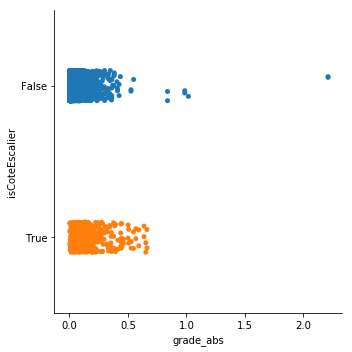

In [27]:
sns.catplot(x="grade_abs", y="isCoteEscalier", data=dfEdgesSJBWithName)

In [28]:
def safeCol(c):
    dictColor={False:"blue", True:"orange"}
    
    if np.isnan(c) == False:
        col=dictColor[c] 
    else:
        col=None
        
    return col

In [29]:
dfEdgesSJBWithName['col'] = [safeCol(c) for c in dfEdgesSJBWithName["isCoteEscalier"]  ]
dfEdgesSJBWithNamePlot = dfEdgesSJBWithName.dropna()

In [30]:
dfEdgesSJBWithName.head()

startNode           startNeigh       endNode             endNeigh  \
0  1.832233e+09  Saint-Jean-Baptiste  1.832233e+09  Saint-Jean-Baptiste   
1  1.774756e+08  Saint-Jean-Baptiste  1.774762e+08  Saint-Jean-Baptiste   
2  1.774756e+08  Saint-Jean-Baptiste  1.652178e+08  Saint-Jean-Baptiste   
3  1.774756e+08  Saint-Jean-Baptiste  3.048305e+08  Saint-Jean-Baptiste   
4  1.832233e+09  Saint-Jean-Baptiste  2.477819e+09  Saint-Jean-Baptiste   

   grade_abs  bearing  startIdx  endIdx pairIdxDirected pairIdxUndirected  \
0     0.1264  350.087         1       1          (1, 1)            (1, 1)   
1     0.0324  328.701         1       1          (1, 1)            (1, 1)   
2     0.0303   58.025         1       1          (1, 1)            (1, 1)   
3     0.0296  238.391         1       1          (1, 1)            (1, 1)   
4     0.2838   15.665         1       1          (1, 1)            (1, 1)   

                          neighPairUndirected  \
0  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)   
1  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)   
2  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)   
3  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)   
4  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)   

                            neighPairDirected                   streetName  \
0  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)                          NaN   
1  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)    Rue Jean-Jacques-Bertrand   
2  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)  Boulevard René-Lévesque Est   
3  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)  Boulevard René-Lévesque Est   
4  (Saint-Jean-Baptiste, Saint-Jean-Baptiste)                          NaN   

  isCoteEscalier isOnlyEscalierInName   col  
0            NaN                  NaN  None  
1          False                False  blue  
2          False                False  blue  
3          False                False  blue  
4            NaN                  NaN  None

In [31]:
sns.distplot(a=dfEdgesSJBWithNamePlot["grade_abs"],
             #color=dfEdgesSJBWithNamePlot["col"], 
             label=dfEdgesSJBWithNamePlot["isCoteEscalier"])

In [32]:
stairPlot=sns.violinplot(x="isCoteEscalier",y="grade_abs",data=dfEdgesSJBWithName,hue='isCoteEscalier',palette='Set1')
fig=stairPlot.get_figure()
stairPlot.set_title("Grade for difference types of street")
fig.savefig(os.path.join(FIG_DIR,"EdgeGrades","violinPlotEscalierCoteRaw.png"))

In [33]:
#What is the outlier?
dfEdgesSJBWithNamePlot.loc[ np.argmax( dfEdgesSJBWithNamePlot.grade_abs ), ]

/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


startNode                            1.75916e+08
startNeigh                            Saint-Roch
endNode                              1.80821e+08
endNeigh                              Saint-Roch
grade_abs                                 2.2105
bearing                                  306.154
startIdx                                       2
endIdx                                         2
pairIdxDirected                           (2, 2)
pairIdxUndirected                         (2, 2)
neighPairUndirected     (Saint-Roch, Saint-Roch)
neighPairDirected       (Saint-Roch, Saint-Roch)
streetName                        Rue Saint-Roch
isCoteEscalier                             False
isOnlyEscalierInName                       False
col                                         blue
Name: 16262, dtype: object

In [34]:
#These are all outliers
dfEdgesSJBWithNamePlot.loc[   dfEdgesSJBWithNamePlot.grade_abs > 1, ]

startNode                                    startNeigh  \
1289   177504504.0  Vieux-Québec/Cap-Blanc/Colline parlementaire   
16262  175916188.0                                    Saint-Roch   
18703  180820726.0                                    Saint-Roch   

            endNode                                      endNeigh  grade_abs  \
1289   4.161405e+09  Vieux-Québec/Cap-Blanc/Colline parlementaire     1.0167   
16262  1.808207e+08                                    Saint-Roch     2.2105   
18703  1.759162e+08                                    Saint-Roch     2.2105   

       bearing  startIdx  endIdx pairIdxDirected pairIdxUndirected  \
1289   280.677         4       4          (4, 4)            (4, 4)   
16262  306.154         2       2          (2, 2)            (2, 2)   
18703  126.154         2       2          (2, 2)            (2, 2)   

                                     neighPairUndirected  \
1289   (Vieux-Québec/Cap-Blanc/Colline parlementaire,...   
16262                           (Saint-Roch, Saint-Roch)   
18703                           (Saint-Roch, Saint-Roch)   

                                       neighPairDirected      streetName  \
1289   (Vieux-Québec/Cap-Blanc/Colline parlementaire,...   Rue Richelieu   
16262                           (Saint-Roch, Saint-Roch)  Rue Saint-Roch   
18703                           (Saint-Roch, Saint-Roch)  Rue Saint-Roch   

      isCoteEscalier isOnlyEscalierInName   col  
1289           False                False  blue  
16262          False                False  blue  
18703          False                False  blue

In [35]:
#Ok this makes no sense - not sure about the data quality - could also be the case that the highway towering above is causing some issues with elevation data
thresh=0.9
dfEdgesSJBWithNamePlotFiltered = dfEdgesSJBWithNamePlot.loc[ dfEdgesSJBWithNamePlot.grade_abs <= thresh ,]

In [36]:
dfEdgesSJBWithNamePlotFiltered.groupby(["startNeigh"]).agg({"grade_abs": "max"}).reset_index()

startNeigh  grade_abs
0                                      Montcalm     0.3001
1                           Saint-Jean-Baptiste     0.3829
2                                    Saint-Roch     0.6373
3                                 Saint-Sauveur     0.6627
4  Vieux-Québec/Cap-Blanc/Colline parlementaire     0.8379

In [37]:
#This data is medium quality at best => Rue Saint-Réal is in SJB and is not that steep..

pd.merge(dfEdgesSJBWithNamePlotFiltered.groupby(["startNeigh"]).agg({"grade_abs": "max"}),
         dfEdgesSJBWithNamePlotFiltered[['grade_abs','streetName','isCoteEscalier','startNeigh']],
         on=["grade_abs",'startNeigh'])

grade_abs                                    startNeigh         streetName  \
0     0.3001                                      Montcalm    Avenue De Laune   
1     0.3829                           Saint-Jean-Baptiste    Avenue Turnbull   
2     0.3829                           Saint-Jean-Baptiste    Avenue Turnbull   
3     0.6373                                    Saint-Roch      Côte Badelard   
4     0.6373                                    Saint-Roch      Côte Badelard   
5     0.6627                                 Saint-Sauveur  Escalier Victoria   
6     0.6627                                 Saint-Sauveur  Escalier Victoria   
7     0.8379  Vieux-Québec/Cap-Blanc/Colline parlementaire     Rue des Glacis   
8     0.8379  Vieux-Québec/Cap-Blanc/Colline parlementaire     Rue des Glacis   

  isCoteEscalier  
0          False  
1          False  
2          False  
3           True  
4           True  
5           True  
6           True  
7          False  
8          False

In [38]:
#What ever... plot the filtered graph anyhow

stairPlot=sns.violinplot(x="isCoteEscalier",y="grade_abs",data=dfEdgesSJBWithNamePlotFiltered,hue='isCoteEscalier',palette='Set1')
fig=stairPlot.get_figure()
stairPlot.set_title("Grade by type of streets")
fig.savefig(os.path.join(FIG_DIR,"Stairs","violinPlotEscalierCote.png"))


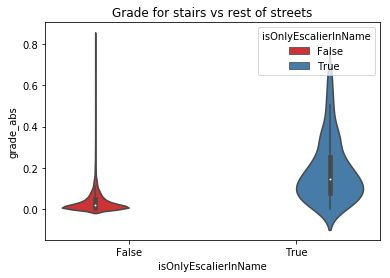

In [39]:
stairPlot=sns.violinplot(x="isOnlyEscalierInName",y="grade_abs",data=dfEdgesSJBWithNamePlotFiltered,hue='isOnlyEscalierInName',palette='Set1')
fig=stairPlot.get_figure()
stairPlot.set_title("Grade for stairs vs rest of streets")
fig.savefig(os.path.join(FIG_DIR,"Stairs","violinPlotEscalierOnlyfiltered.png"))

# Plot the graph and show streets

In [40]:
def safeGrep(n):
    name=None
    try:
        grepMatch=re.match( "escalier" ,n ,re.IGNORECASE)
        if(grepMatch is not None):
            name=n
    except Exception as e:
        pass
    return(name)

In [41]:
def safeColStairs(c):
    col="blue"
    
    if c is not None :
        col="red"
 
    return col

In [91]:
def safeColStairsAcrossNeigh(c, u,v):

    if c is not None and u != v:
        col="red"
    elif c is not None :
        col="orange"
    else:
        col="blue"
 
    return col

In [42]:
def safeSizeStairs(c):
    s=1
    
    if c is not None :
        s=4
 
    return s

In [67]:
def safeStartNeig(u):
    try:
        return( dfEdgesSJB.startNeigh [ dfEdgesSJB.startNode == u].unique()[0] )
    except Exception as e:
        print(f"Fatal error getting start neigh with {u}", e)
    

In [76]:
def safeEndNeig(v):
    try:
        return( dfEdgesSJB.endNeigh [ dfEdgesSJB.endNode == v].unique()[0] )
    except Exception as e:
        print(f"Fatal error getting end neigh with {v}", e)

In [43]:
listStreetNamesRaw = [ getNameSafe(dat) for u,v,dat in graphSJB.edges.data()   ]
grepStreet=[safeGrep(n) for n in listStreetNamesRaw ]
listStairsColors=[safeColStairs(g) for g in grepStreet ]
listStairsSize=[safeSizeStairs(g) for g in grepStreet]

In [69]:
listStartNeigh=[ safeStartNeig(u) for u,v,dat in graphSJB.edges.data()   ]

In [77]:
listEndNeigh=[ safeEndNeig(v) for u,v,dat in graphSJB.edges.data()   ] 

In [79]:
print( listStartNeigh[:2], listEndNeigh[:2] )

['Montcalm', 'Montcalm'] ['Montcalm', 'Montcalm']


In [84]:
print(grepStreet[15])

None


In [92]:
listStairsColorsAcrossNeigh= [ safeColStairsAcrossNeigh(grepStreet[k],
                                                        listStartNeigh[k],
                                                        listEndNeigh[k]) \
                              for k in range(len(listStartNeigh)) ]

In [ ]:
#Plot the graph with all stairs

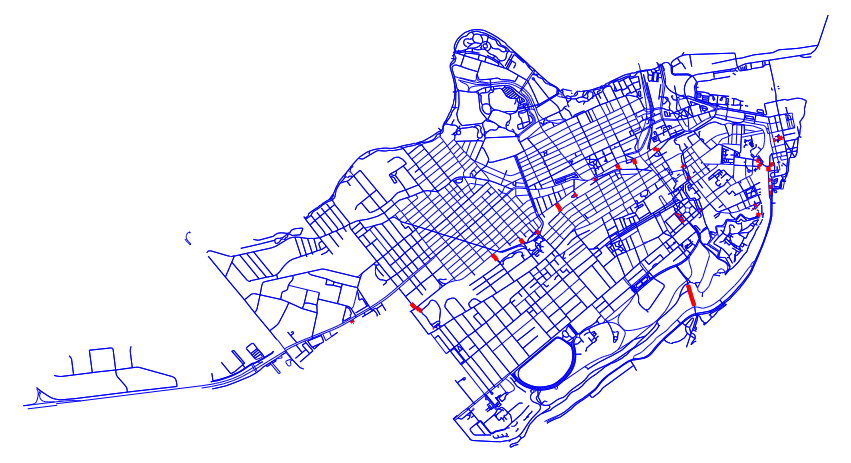

In [44]:
fig, ax = ox.plot_graph(graphSJB , 
                        fig_height=15, 
                        fig_width=15,
                        node_size=0, 
                        node_zorder=2, 
                        edge_color=listStairsColors,
                        edge_linewidth=listStairsSize,
                        close=False,
                        show=False,
                       )
#fig.suptitle("Quebec stairs")
fig.savefig(os.path.join(ROOT_DIR,"Figures","Stairs", "qcStairs.png"))

In [80]:
#Plot the graph with stairs between neighbourhoods in a different color

In [93]:
fig, ax = ox.plot_graph(graphSJB , 
                        fig_height=15, 
                        fig_width=15,
                        node_size=0, 
                        node_zorder=2, 
                        edge_color=listStairsColorsAcrossNeigh,
                        edge_linewidth=listStairsSize,
                        close=False,
                        show=False,
                       )
#fig.suptitle("Quebec stairs")
fig.savefig(os.path.join(ROOT_DIR,"Figures","Stairs", "qcStairsAcross.png"))

In [ ]:
#Fuck it, easier to simply create the shp file
#Need to create the feature attribute first

In [106]:
for u,v,dat in graphSJB.edges(data=True):
    dat["startNeigh"] = safeStartNeig(u)
    dat["endNeigh"] =safeEndNeig(v)
    name=getNameSafe(dat)
    grepMatch=safeGrep(name)
    
    if( dat["startNeigh"] !=  dat["endNeigh"]  and grepMatch is not None):
         dat["isStairAccross"] = 1
    elif grepMatch is not None:
        dat["isStairAccross"] = 2
    else :
        dat["isStairAccross"] = 3
    
    
    

In [107]:
np.unique([dat['isStairAccross'] for u,v,dat in  graphSJB.edges(data=True) ] )

array([1, 2, 3])

In [108]:
#Write the graph

In [109]:
ox.save_graph_shapefile(graphSJB, filename=os.path.join(DATA_DIR, "GeoData","GraphShp", "centralNeighWithStairs.shp"))